**Import all the Dependencies**

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

**Set all the constants**

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

**Import data into tensorflow dataset object**

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../dataset/Data_transfer_learning/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7178 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['CANCER', 'COVID19', 'NORMAL', 'PNEUMONIA']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 0 1 2 2 1 3 1 0 0 3 2 0 2 1 1 1 3 3 0 0 2 0 0 2 2 0 3 2 0 0]


# Visualize some of the images from our dataset

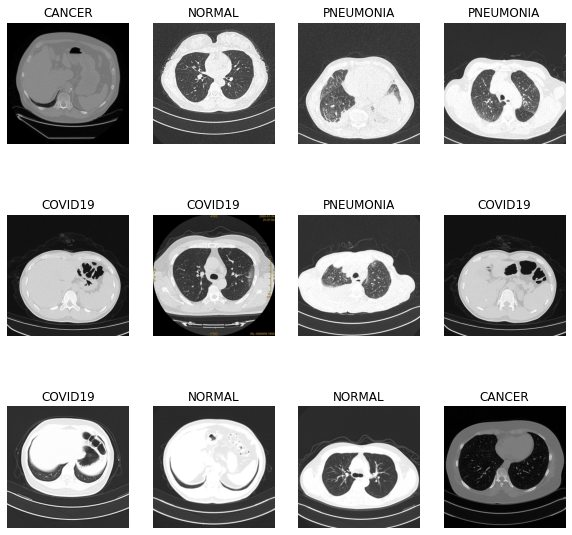

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# *Building the Model*

# 3- Inception V3

In [7]:
train_datagen = ImageDataGenerator (rescale = 1./255,
                                   rotation_range = 8,
                                   zoom_range = 0.15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.10,
                                   horizontal_flip = True,
                                   brightness_range = [0.8, 1.2],
                                   channel_shift_range = 0.15,
                                   fill_mode = "nearest")
test_datagen = ImageDataGenerator(rescale = 1./255)

x_train = train_datagen.flow_from_directory('../dataset/Data_transfer_learning/train',
                                            target_size = (299,299), batch_size = 32, 
                                            class_mode = 'binary')
x_test = test_datagen.flow_from_directory('../dataset/Data_transfer_learning/test',
                                            target_size = (299,299), batch_size = 32, 
                                            class_mode = 'binary', shuffle = False)

print (x_train.class_indices)

Found 7178 images belonging to 4 classes.
Found 2054 images belonging to 4 classes.
{'CANCER': 0, 'COVID19': 1, 'NORMAL': 2, 'PNEUMONIA': 3}


In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [11]:
base_model = InceptionV3(input_shape=(299, 299, 3),
                  include_top = False,
                  input_tensor = None,
                  weights = "imagenet")
for layer in base_model.layers:
    layer.trainable = False
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation = 'relu')(x)

# add dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# add a final signoid layer for classification
x = layers.Dense(1, activation = 'sigmoid')(x)

model_InceptionV3 = tf.keras.models.Model(base_model.input, x)

87916544/87910968 [==============================] - 49s 1us/step


In [12]:
model_InceptionV3.compile(loss = "binary_crossentropy",
             optimizer = 'adam',
             metrics = ['accuracy'])

train_count = len(x_train.filepaths)
test_count = len(x_test.filepaths)
train_steps_per_epoch = round(train_count/32)
val_steps_per_epoch = round(test_count/32)

print(f"TRAIN STEPS PER EPOCH: {train_steps_per_epoch}")
print(f"VAL STEPS PER EPOCH: {val_steps_per_epoch}")

TRAIN STEPS PER EPOCH: 224
VAL STEPS PER EPOCH: 64


In [ ]:
history = model_InceptionV3.fit_generator(x_train, steps_per_epoch = train_steps_per_epoch,
                             epochs = 20, validation_data = x_test, 
                             validation_steps = val_steps_per_epoch)


C:\Users\Abdel Aziz\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
224/224 [==============================] - 897s 4s/step - loss: -94011.5547 - accuracy: 0.2032 - val_loss: -235716.5938 - val_accuracy: 0.2046
Epoch 2/20
224/224 [==============================] - 772s 3s/step - loss: -686558.1875 - accuracy: 0.2040 - val_loss: -969112.1875 - val_accuracy: 0.2046
Epoch 3/20
224/224 [==============================] - 817s 4s/step - loss: -1897388.8750 - accuracy: 0.2043 - val_loss: -2185962.0000 - val_accuracy: 0.2046
Epoch 4/20
224/224 [==============================] - 782s 3s/step - loss: -3661716.0000 - accuracy: 0.2036 - val_loss: -3845822.0000 - val_accuracy: 0.2046
Epoch 5/20
224/224 [==============================] - 776s 3s/step - loss: -5907685.5000 - accuracy: 0.2043 - val_loss: -5879621.5000 - val_accuracy: 0.2046
Epoch 6/20
224/224 [==============================] - 773s 3s/step - loss: -8700875.0000 - accuracy: 0.2043 - val_loss: -8328911.0000 - val_accuracy: 0.2046
Epoch 7/20
224/224 [==============================] - ETA: 0s -

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred=model_InceptionV3.predict(x_test)

threshold = 0.5

y_pred_threshold = = [(1 if val>threshold else 0 ) for val in y_pred]

y_true = x_test.labels.tolist()

print (confusion_matrix(y_true, y_pred_threshold))
print (accuracy_score(y_true, y_pred_threshold))

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred_threshold), annot = True)
keys = history.history.keys
print(keys)

plt.figure(1, figsize = (15, 8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.show()

for key in keys:
    plt.figure(figsize = (15, 2))
    plt.plot(history.history[key])
    plt.title(key)
    plt.ylabel(key)
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'])
    plt.show()    

# Saving the Model

In [ ]:
#Save VGG16 model
model_InceptionV3.save("../model_InceptionV3.h5")